# Budget Analysis V1

This is my second attempt at viewing my spending data. In `v0`, we explored how to deduplicate the data across `*.csv` files for when I arbitrarily download multiple files. First, I'm going to construct all the AI generated code into the block below.

In [2]:
import finance_cleaner as fc

df = fc.clean_transactions("../data/transactions_*.csv")
df.to_csv('../data/finance_cleaner_output.csv')


=== READING IN FILES ===

✅ Read in frame transactions_2025_06_13.csv with shape (1988, 9)
✅ Read in frame transactions_dummy_to_test_duplicates.csv with shape (1988, 9)

=== CONVERTING TYPES ===

✅ Converted date string to_datetime
✅ Converted boolean strings to boolean
✅ Converted boolean strings to boolean
✅ Converted amount strings to numeric

=== ADDING ROW HASHES ===

✅ Created columns IntraKey, CrossKey, and RowID
✅ Set RowID as index

=== COALESCING DUPLICATES on key='CrossKey' ===

  Merging 2 rows for group '0a85a'. RowIDs: ['0a85a_1', '0a85a_2']
  Merging 2 rows for group '0dd4d'. RowIDs: ['0dd4d_1', '0dd4d_2']
  Merging 3 rows for group '0f0d5'. RowIDs: ['0f0d5_1', '0f0d5_2', '0f0d5_3']
  ... (remaining rows hidden)

✅ Total rows after de-duplication: 3885

=== REMOVING DUPLICATES on key='IntraKey' ===

  Removing 1939 duplicate rows:
  RowID: 47 | Date: 2025-02-10 00:00:00 | Desc: FID BKG SVC LLC DES MONEYLINE INDN LEN G HUANG CO PPD | Amt: -200.0
  RowID: 82 | Date: 2024

# LLM Integration

Let's do some set up so that we can use LLM's to parse and understand our CSV.

In [3]:
from openrouter import OpenRouterClient

# Set up the client
client = OpenRouterClient()

# Get first 5 rows as string
first_5_rows = df.head(5).to_string()

# Query LLM with budget expert system prompt
response = client.quick_query(
    first_5_rows,
    system_message="Provide a brief summary of this transaction data, with short sentences and bullet points"
)

print("\n=== Budget Analysis ===")
print(response)


=== Budget Analysis ===
Here's a summary of the transaction data:

*   **Transactions** include transfers, energy expenses, rideshares, and income.
*   **Amounts** range from negative (e.g., -$400.00) to positive (e.g., $97.57).
*   **Accounts** are from Adv Plus Banking (Bank of America) and Venmo.
*   **Categories** include Transfers, Energy, Rideshare, and Income.
*   **Dates** range from January 2024 to June 2025.
*   **Descriptions** detail the transaction (e.g., "ELECTRICITY JULY AUG").
*   **Source** is either Bank of America or Venmo via different connection methods.



# More Nuanced Category Understanding

With this in mind, we can seek to accomplish a more nuanced understanding of how we organize data. Rather than providing hardcoded regex rules, I seek to provide a list of human language rules that we can use to get more nuanced understandings of the data. I'm imagining something where we supply the unique values of descriptions x categories to an LLM, have it create smart categories, and then compare and contrast the pie charts for those.

In [4]:
import pandas as pd

def breakdown_by_category(input_df, groupby_key="Category"):
    # Exclude 'Transfers' category
    df = input_df[input_df['Category'] != 'Transfers']

    # Separate spending and income
    spending = df[df['Amount'] < 0].copy()
    income = df[df['Amount'] > 0].copy()

    # Convert spending amounts to positive for analysis
    spending['Amount'] = spending['Amount'].abs()

    # Calculate spending and income by category (sorted ascending)
    spending_by_category = spending.groupby(groupby_key)['Amount'].sum().sort_values()
    income_by_category = income.groupby(groupby_key)['Amount'].sum().sort_values()

    return spending_by_category, income_by_category


def understand_categories(input_df, groupby_key="Category"):

    spending_by_category, income_by_category = breakdown_by_category(input_df, groupby_key)

    # Calculate percentages
    print("\n=== SPENDING PERCENTAGES ===")
    print((spending_by_category / spending_by_category.sum() * 100).round(1))
    print("\n=== INCOME PERCENTAGES ===")
    print((income_by_category / income_by_category.sum() * 100).round(1))


# Load and prepare data
understand_categories(pd.read_csv('../data/finance_cleaner_output.csv'))


=== SPENDING PERCENTAGES ===
Category
Pets                             0.0
Auto Service                     0.0
Education                        0.0
Bank Fee                         0.0
Health & Fitness                 0.0
Books                            0.0
Gifts                            0.0
Checks                           0.0
Gas & Fuel                       0.0
Tolls                            0.0
Household Services               0.0
Personal Care                    0.0
Entertainment                    0.0
Auto & Transport                 0.0
Insurance                        0.0
Home Improvement/Maintenance     0.0
Electronics & Software           0.0
Taxes                            0.0
Pharmacy                         0.0
Concerts & Events                0.0
Subscriptions                    0.1
Other                            0.1
Energy, Gas & Electric           0.1
Hair & Nails                     0.1
Coffee                           0.1
Water                            0.1

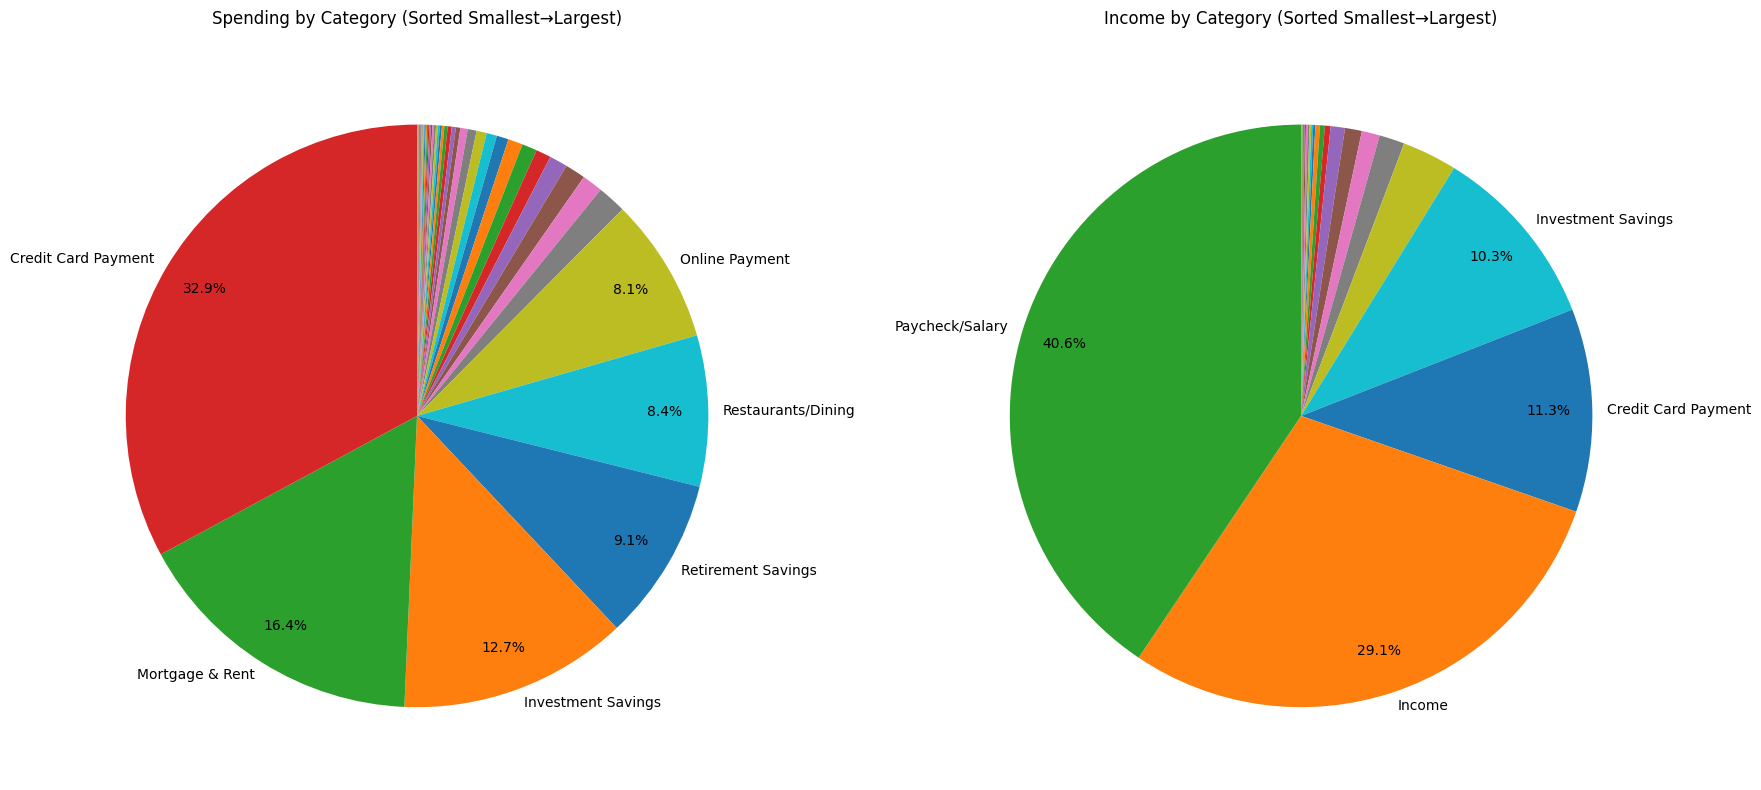

In [5]:
import matplotlib.pyplot as plt

def graph_categories(input_df, groupby_key="Category"):

    spending_by_category, income_by_category = breakdown_by_category(input_df, groupby_key)

    def make_autopct(values):
        def my_autopct(pct):
            return '%1.1f%%' % pct if pct > 5 else ''
        return my_autopct

    plt.figure(figsize=(18, 8))

    # Spending pie chart
    plt.subplot(1, 2, 1)
    values = spending_by_category.values
    labels = [label if (value/sum(values)*100) > 5 else ''
            for label, value in zip(spending_by_category.index, values)]

    plt.pie(
        values,
        labels=labels,
        autopct=make_autopct(values),
        startangle=90,
        pctdistance=0.85,
        labeldistance=1.05,
        counterclock=False
    )
    plt.title('Spending by Category (Sorted Smallest→Largest)', pad=20)

    # Income pie chart
    plt.subplot(1, 2, 2)
    values = income_by_category.values
    labels = [label if (value/sum(values)*100) > 5 else ''
            for label, value in zip(income_by_category.index, values)]

    plt.pie(
        values,
        labels=labels,
        autopct=make_autopct(values),
        startangle=90,
        pctdistance=0.85,
        labeldistance=1.05,
        counterclock=False
    )
    plt.title('Income by Category (Sorted Smallest→Largest)', pad=20)

    plt.tight_layout()
    plt.show()

graph_categories(pd.read_csv('../data/finance_cleaner_output.csv'))

From this, I'm making a few observations:
- I should coalesce credit card reversals into credit card spending rather than as true "income", as this may be misleading.
- I should add more detail to "income" because I'm not sure if that may be referring to Venmo payments.
- I should understand what "Retirement Savings" vs "Investment Savings" is as well, and how they may be different. They show up in both income and spending too.
- I have a long tail of "other" categories that need understanding too.

Let's try to provide the LLM some data about the various categories and weight it by amount.

In [6]:
# Load and prepare your data
df = pd.read_csv('../data/finance_cleaner_output.csv')

# Add transaction type and remove amount
df['TransactionType'] = df['Amount'].apply(lambda x: 'Income' if x > 0 else 'Spending')
df = df.drop('Amount', axis=1)

# Group and count transactions
grouped_df = df.groupby(['Account', 'Category', 'Description', 'Institution', 'TransactionType']).size().reset_index(name='Count')

# Calculate total counts for percentage calculation
total_transactions = len(df)
total_income = len(df[df['TransactionType'] == 'Income'])
total_spending = len(df[df['TransactionType'] == 'Spending'])

# Add percentage columns
grouped_df['PercentageOfTotal'] = (grouped_df['Count'] / total_transactions * 100).round(2)
grouped_df['PercentageOfType'] = grouped_df.apply(
    lambda row: round(row['Count'] / total_income * 100, 2) if row['TransactionType'] == 'Income'
    else round(row['Count'] / total_spending * 100, 2),
    axis=1
)

# Format percentages
grouped_df['PercentageOfTotal'] = grouped_df['PercentageOfTotal'].astype(str) + '%'
grouped_df['PercentageOfType'] = grouped_df['PercentageOfType'].astype(str) + '%'

# Sort results
grouped_df = grouped_df.sort_values('Count', ascending=False)

# Display
grouped_df

,Account,Category,Description,Institution,TransactionType,Count,PercentageOfTotal,PercentageOfType
61,Adv Plus Banking - 2082,Transfers,ALLY BANK DES TRANSFER INDN LEN G HUANG CO WEB,Bank of America - via Direct Web API,Spending,86,4.42%,6.49%
70,Ally Savings Account,Transfers,REQUESTED TRANSFER FROM LEN G HUANG ALLY BANK ...,Ally,Income,82,4.21%,13.23%
119,Biweekly Index Funds,Investment Savings,MONEY LINE RECEIVED EFT FUNDS RECEIVED,Fidelity Investments - via Fidelity Access,Income,41,2.11%,6.61%
312,Other Spending,Groceries,TRADER JOES,Chase,Spending,40,2.06%,3.02%
49,Adv Plus Banking - 2082,Paycheck/Salary,STUBHUB INC DES PAYROLL ID INDN HUANG LEN CO PPD,Bank of America - via Direct Web API,Income,37,1.9%,5.97%
...,...,...,...,...,...,...,...,...
371,Other Spending,Restaurants/Dining,LE POISSON ROUGE,Chase,Spending,1,0.05%,0.08%
372,Other Spending,Restaurants/Dining,LGA FLATIRON TAVERN,Chase,Spending,1,0.05%,0.08%
373,Other Spending,Restaurants/Dining,LIBERTY BA LIBERTY BA,Chase,Spending,1,0.05%,0.08%
374,Other Spending,Restaurants/Dining,LS BIKE AND SPIN,Chase,Spending,1,0.05%,0.08%


Let's try to feed this into an LLM to understand better.

In [7]:
# llm_prompt = client.quick_query(
#     grouped_df.to_string(),
#     system_message="How would you prompt an LLM to get smart categorizations of this data, weighted by the percentages?"
# )

# print(llm_prompt)

In [8]:
# smart_categories = client.quick_query(
#     grouped_df.to_string(),
#     system_message=llm_prompt,
# )

# print(smart_categories)

# Hard Coded Rule Generation

I decided that this was low key not that useful lol. So I decided to instead opt for some more hardcoded rules. However, I did use LLM's to help me generate those rules / come to this conclusion.


=== SPENDING PERCENTAGES ===
Smarter Category
Dining Out - Quick Bites     0.0
Groceries                    0.9
Uncategorized Spending      99.1
Name: Amount, dtype: float64

=== INCOME PERCENTAGES ===
Smarter Category
Expense Reimbursements     0.9
Uncategorized Income      99.1
Name: Amount, dtype: float64


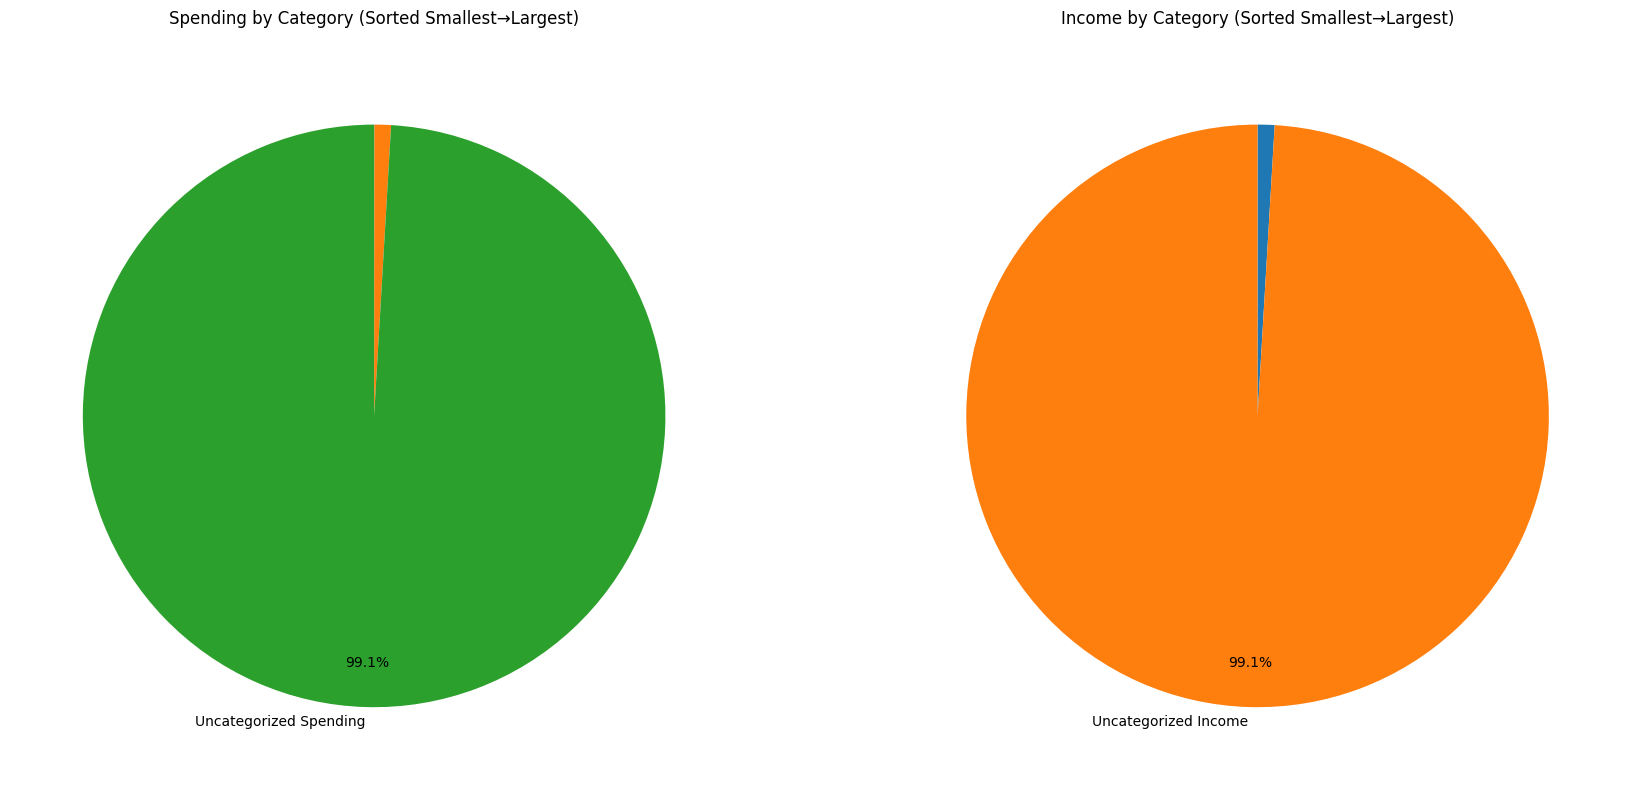

In [18]:
from rules_engine import RuleEngine
import pandas as pd

re = RuleEngine()
df = pd.read_csv('../data/finance_cleaner_output.csv')
df = re.classify_dataframe(df)

understand_categories(df, groupby_key='Smarter Category')
graph_categories(df, groupby_key='Smarter Category')

In [19]:
# Filter to keep only rows where Category is "Uncategorized"
df[df['Smarter Category'].str.startswith('Uncategorized', na=False)]

,Unnamed: 0,CrossKey,Amount,Account,Category,Date,Description,Institution,IntraKey,Is Hidden,Is Pending,SourceFile,Smarter Category
0,0,00072,-225.00,Adv Plus Banking - 2082,Transfers,2024-01-24,ALLY BANK DES TRANSFER INDN LEN G HUANG CO WEB,Bank of America - via Direct Web API,ce498,False,False,transactions_2025_06_13.csv,Uncategorized Spending
1,1,00081,-400.00,Adv Plus Banking - 2082,Transfers,2025-06-11,ALLY BANK DES TRANSFER INDN LEN G HUANG CO WEB,Bank of America - via Direct Web API,80595,False,False,transactions_2025_06_13.csv,Uncategorized Spending
3,3,005ee,18.97,Venmo,Rideshare,2024-05-19,LYFT TO LOUD LUXURY THERE AND BACK,Venmo - via Direct Web Access,9fa9b,False,False,transactions_dummy_to_test_duplicates.csv,Uncategorized Income
4,4,0060d,73.85,Venmo,Income,2024-01-27,PICKLE,Venmo - via Direct Web Access,01ab4,False,False,transactions_2025_06_13.csv,Uncategorized Income
5,5,006d8,-15.23,Venmo,Restaurants/Dining,2024-03-15,HAVE A HAPPY JOLLY CHRISTMAS IT S THE BEST TIM...,Venmo - via Direct Web Access,33eca,False,False,transactions_dummy_to_test_duplicates.csv,Uncategorized Spending
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,3696,f406a,-6.41,Customized Cash Rewards Visa Signature - 0966,Subscriptions,2024-04-29,SPOTIFY NY,Bank of America - via Direct Web API,0a387,False,False,transactions_2025_06_13.csv,Uncategorized Spending
1942,3703,f4795,32.28,Venmo,Restaurants/Dining,2024-08-24,TOP OF THE HILL DINNER,Venmo - via Direct Web Access,c15ff,False,False,transactions_2025_06_13.csv,Uncategorized Income
1943,3712,f4d6f,243.95,CREDIT CARD,Credit Card Payment,2024-07-24,PAYMENT THANK YOUMOBILE,Chase,94f79,False,False,transactions_2025_06_13.csv,Uncategorized Income
1944,3726,f5ca5,-6.26,BILT WORLD ELITE MASTERCARD ...7685,Restaurants/Dining,2024-08-10,SQ LATELY CAFE QUEENS NY,Wells Fargo Online Banking - via Direct Web API,3c0b7,False,False,transactions_dummy_to_test_duplicates.csv,Uncategorized Spending
